# Импорты

In [72]:
import numpy as np
from scipy.stats import norm
import networkx as nx
from collections import defaultdict
from matplotlib import pyplot as plt
import pandas as pd

# Импорт всех данных из варианта
from base.task_option import *

# Класс сетевого анализа

In [73]:
class NetworkPlanning:
    def __init__(self):
        self.works = {}
        self.dummy_list = []
        self.graph = nx.DiGraph()
        
    def add_link(self, linked_tasks, num_nodes):
        """
        Добавление связей между работами на основе структуры linked_tasks
        """
        # Используем атрибут класса, а не локальную переменную
        self.graph = nx.DiGraph()

        # Добавляем узлы
        for i in range(num_nodes):
            self.graph.add_node(i)

        # Создаем словарь для быстрого доступа к этапам работ
        task_stages = {name: stages for name, stages in linked_tasks}
        
        # Добавляем реальные работы
        for name, stages in linked_tasks:
            if name not in self.works:
                continue
                
            work = self.works[name]
            self.graph.add_edge(
                stages[0],  # Начало ребра
                stages[1],  # Конец ребра
                task=name,
                duration=work['t_pes'],
                real=True
            )

        # Создаем словарь для быстрого доступа к работам по имени
        task_dict = {name: self.works[name] for name in self.works if name in task_stages}

        # Добавляем фиктивные работы
        self.dummy_list = []
        
        for name, stages in linked_tasks:
            if name not in self.works:
                continue
                
            work = self.works[name]
            
            for dep_name in work['dependencies']:
                if dep_name == '-':
                    continue
                    
                if dep_name in task_stages:
                    dep_stages = task_stages[dep_name]
                    start = stages[0]  # Начало текущей задачи
                    dep_end = dep_stages[1]  # Окончание зависимости

                    # Проверяем необходимость фиктивной работы
                    if dep_end != start:
                        has_connection = False

                        # Проверяем все входящие ребра в начальный этап текущей задачи
                        for u, v, d in self.graph.in_edges(start, data=True):
                            if v == start and u == dep_end:
                                has_connection = True
                                break

                        # Добавляем фиктивное ребро при отсутствии соединения
                        if not has_connection:
                            self.dummy_list.append((dep_end, start))
                            dummy_label = f"dummy_{dep_end}_{start}"
                            self.graph.add_edge(
                                dep_end, 
                                start, 
                                task=dummy_label,
                                duration=0, 
                                real=False
                            )
    
    def get_graph(self):
        """Возвращает граф проекта"""
        return self.graph
    
    def get_dummy_list(self):
        """Возвращает список фиктивных работ"""
        return self.dummy_list.copy()

    def add_work(self, name, dependencies, t_pes, t_ver, t_opt, cost_reduction=None):
        """Добавление работы с её характеристиками"""
        self.works[name] = {
            'dependencies': dependencies,
            't_pes': t_pes,
            't_ver': t_ver,
            't_opt': t_opt,
            'cost_reduction': cost_reduction
        }
    
    def calculate_three_param_model(self):
        """Расчет для трехпараметрической модели"""
        results = {}
        for name, work in self.works.items():
            t_oj = (work['t_pes'] + 4 * work['t_ver'] + work['t_opt']) / 6
            variance = ((work['t_pes'] - work['t_opt']) / 6) ** 2
            
            results[name] = {
                't_oj': round(t_oj),
                'variance': round(variance, 2)
            }
        return results
    
    def calculate_two_param_model(self):
        """Расчет для двухпараметрической модели"""
        results = {}
        for name, work in self.works.items():
            t_oj_star = (3 * work['t_pes'] + 2 * work['t_opt']) / 5
            variance = ((work['t_pes'] - work['t_opt']) / 6) ** 2
            
            results[name] = {
                't_oj_star': round(t_oj_star),
                'variance': round(variance, 2)
            }
        return results
    
    def build_network(self, model_type='three_param'):
        """Построение сетевого графика"""
        self.graph.clear()
        
        if model_type == 'three_param':
            model_results = self.calculate_three_param_model()
            time_key = 't_oj'
        else:
            model_results = self.calculate_two_param_model()
            time_key = 't_oj_star'
        
        # Создаем узлы на основе зависимостей
        node_counter = 0
        event_nodes = {}
        
        # Начальное событие
        event_nodes['start'] = node_counter
        node_counter += 1
        
        # Создаем узлы для каждой работы
        for name, work in self.works.items():
            if work['dependencies'] == ['-']:
                start_event = 'start'
            else:
                # Для упрощения создаем узел после зависимостей
                start_event = f"after_{'_'.join(work['dependencies'])}"
            
            end_event = f"end_{name}"
            
            if start_event not in event_nodes:
                event_nodes[start_event] = node_counter
                node_counter += 1
            if end_event not in event_nodes:
                event_nodes[end_event] = node_counter
                node_counter += 1
            
            self.graph.add_edge(
                event_nodes[start_event], 
                event_nodes[end_event], 
                weight=model_results[name][time_key],
                duration=model_results[name][time_key],
                variance=model_results[name]['variance'],
                name=name
            )
        
        return self.graph
    
    def find_critical_path(self, model_type='three_param'):
        """Нахождение критического пути через узлы графа"""
        graph = self.build_network(model_type)
        
        try:
            # Находим самый длинный путь (критический путь) через узлы
            longest_path_nodes = nx.dag_longest_path(graph, weight='weight')
            critical_time = nx.dag_longest_path_length(graph, weight='weight')
            
            # Находим работы на критическом пути
            critical_works = []
            total_variance = 0
            
            for i in range(len(longest_path_nodes) - 1):
                edge_data = graph[longest_path_nodes[i]][longest_path_nodes[i+1]]
                critical_works.append(edge_data['name'])
                total_variance += edge_data['variance']
            
            sigma = np.sqrt(total_variance)
            
            return {
                'critical_time': critical_time,
                'critical_works': critical_works,
                'critical_nodes': longest_path_nodes,  # Добавляем узлы пути
                'total_variance': total_variance,
                'sigma': sigma
            }
        except nx.NetworkXError:
            return None
    
    def calculate_probability(self, T_dir, model_type='three_param'):
        """Расчет вероятности выполнения проекта к заданному сроку"""
        critical_path = self.find_critical_path(model_type)
        if not critical_path:
            return None
        
        T_kr = critical_path['critical_time']
        sigma = critical_path['sigma']
        
        z = (T_dir - T_kr) / sigma
        laplas_func_aproctimation = 0.5
        probability = laplas_func_aproctimation + norm.cdf(z) - laplas_func_aproctimation
        
        return probability
    
    def guaranteed_interval(self, P=0.9973, model_type='three_param'):
        """Интервал гарантированного времени выполнения"""
        critical_path = self.find_critical_path(model_type)
        if not critical_path:
            return None
        
        T_kr = critical_path['critical_time']
        sigma = critical_path['sigma']
        
        if P == 0.9973:
            delta = 3 * sigma
        else:
            z = norm.ppf((1 + P) / 2)
            delta = z * sigma
        
        return (T_kr - delta, T_kr + delta)
    
    def max_duration_with_reliability(self, gamma=0.95, model_type='three_param'):
        """Максимальный срок выполнения с заданной надежностью"""
        critical_path = self.find_critical_path(model_type)
        if not critical_path:
            return None
        
        T_kr = critical_path['critical_time']
        sigma = critical_path['sigma']
        
        z_gamma = norm.ppf(gamma)
        T_max = T_kr + z_gamma * sigma
        
        return T_max
    
    def optimize_project_duration(self, target_duration, model_type='three_param'):
        """Оптимизация сроков проекта с минимальными затратами"""
        critical_path = self.find_critical_path(model_type)
        if not critical_path:
            return None
        
        current_duration = critical_path['critical_time']
        needed_reduction = current_duration - target_duration
        
        if needed_reduction <= 0:
            return {"total_cost": 0, "reductions": []}
        
    def analyze_cost_reduction(self, model_type='three_param'):
        """Анализ возможностей сокращения сроков и затрат"""
        critical_works = self.find_critical_path(model_type)['critical_works']
        
        reduction_options = []
        for work in critical_works:
            if self.works[work]['cost_reduction']:
                reduction_options.append({
                    'work': work,
                    'cost_per_day': self.works[work]['cost_reduction'],
                    'max_reduction': self.calculate_max_reduction(work)
                })
        
        # Сортировка по стоимости сокращения (от самой дешевой)
        return sorted(reduction_options, key=lambda x: x['cost_per_day'])
    
    def calculate_max_reduction(self, work_name):
        """Расчет максимального возможного сокращения работы"""
        work = self.works[work_name]
        # Максимальное сокращение = t_опт (минимальное время)
        current_time = (work['t_pes'] + 4 * work['t_ver'] + work['t_opt']) / 6
        max_reduction = current_time - work['t_opt']
        return max(0, max_reduction)
    
    def calculate_total_cost(self, duration, daily_cost, model_type='three_param'):
        """Расчет общей стоимости проекта"""
        base_duration = self.find_critical_path(model_type)['critical_time']
        
        if duration >= base_duration:
            return daily_cost * duration
        
        # Если срок сокращен, добавляем затраты на ускорение
        optimization_result = self.optimize_project_duration(duration, model_type)
        acceleration_cost = optimization_result['total_cost'] if optimization_result else 0
        
        return (daily_cost * duration) + acceleration_cost

# Основные расчеты

In [74]:
# Создаем экземпляр класса
np_solver = NetworkPlanning()

for work in works_data:
    np_solver.add_work(*work)

print("=== ТРЕХПАРАМЕТРИЧЕСКАЯ МОДЕЛЬ ===")

# Расчет ожидаемого времени и дисперсии
three_param = np_solver.calculate_three_param_model()
print("\nОжидаемое время и дисперсия (трехпараметрическая модель):")
for work, values in three_param.items():
    print(f"{work}: t_ож = {values['t_oj']}, D(x) = {values['variance']}")

# Критический путь
critical_3param = np_solver.find_critical_path('three_param')
if critical_3param:
    print(f"\nКритический путь: {critical_3param['critical_works']}")
    print(f"Ожидаемое время выполнения: {critical_3param['critical_time']} дней")
    print(f"Дисперсия критического пути: {critical_3param['total_variance']:.2f}")
    print(f"Среднеквадратическое отклонение: {critical_3param['sigma']:.2f}")
    
    # Вероятность выполнения к сроку
    prob_3param = np_solver.calculate_probability(T_dir, 'three_param')
    print(f"\nВероятность выполнения к сроку {T_dir} дней: {prob_3param:.2%}")
    
    # Интервал гарантированного выполнения
    interval_3param = np_solver.guaranteed_interval(0.9973, 'three_param')
    print(f"Интервал гарантированного выполнения (P=0.9973): {interval_3param[0]:.1f} - {interval_3param[1]:.1f} дней")
    
    # Максимальный срок с надежностью
    max_duration_3param = np_solver.max_duration_with_reliability(gamma, 'three_param')
    print(f"Максимальный срок с надежностью {gamma}: {max_duration_3param:.1f} дней")

print("\n=== ДВУХПАРАМЕТРИЧЕСКАЯ МОДЕЛЬ ===")

# Расчет для двухпараметрической модели
two_param = np_solver.calculate_two_param_model()
print("\nОжидаемое время и дисперсия (двухпараметрическая модель):")
for work, values in two_param.items():
    print(f"{work}: t*_ож = {values['t_oj_star']}, D(x) = {values['variance']}")

# Критический путь
critical_2param = np_solver.find_critical_path('two_param')
if critical_2param:
    print(f"\nКритический путь: {critical_2param['critical_works']}")
    print(f"Ожидаемое время выполнения: {critical_2param['critical_time']} дней")
    
    # Вероятность выполнения к сроку
    prob_2param = np_solver.calculate_probability(T_dir, 'two_param')
    print(f"\nВероятность выполнения к сроку {T_dir} дней: {prob_2param:.2%}")
    
    # Интервал гарантированного выполнения
    interval_2param = np_solver.guaranteed_interval(0.9973, 'two_param')
    print(f"Интервал гарантированного выполнения (P=0.9973): {interval_2param[0]:.1f} - {interval_2param[1]:.1f} дней")
    
    # Максимальный срок с надежностью
    max_duration_2param = np_solver.max_duration_with_reliability(gamma, 'two_param')
    print(f"Максимальный срок с надежностью {gamma}: {max_duration_2param:.1f} дней")

print("\n=== СРАВНЕНИЕ РЕЗУЛЬТАТОВ ===")
if critical_3param and critical_2param:
    print(f"Разница в ожидаемом времени: {critical_2param['critical_time'] - critical_3param['critical_time']} дней")
    print(f"Разница в вероятности выполнения: {prob_2param - prob_3param:.2%}")

=== ТРЕХПАРАМЕТРИЧЕСКАЯ МОДЕЛЬ ===

Ожидаемое время и дисперсия (трехпараметрическая модель):
b1: t_ож = 6, D(x) = 0.69
b2: t_ож = 4, D(x) = 0.44
b3: t_ож = 10, D(x) = 1.36
b4: t_ож = 2, D(x) = 0.25
b5: t_ож = 4, D(x) = 0.25
b6: t_ож = 8, D(x) = 1.0
b7: t_ож = 3, D(x) = 0.69
b8: t_ож = 4, D(x) = 1.36
b9: t_ож = 6, D(x) = 1.36
b10: t_ож = 5, D(x) = 0.44
b11: t_ож = 9, D(x) = 1.0

Критический путь: ['b3']
Ожидаемое время выполнения: 10 дней
Дисперсия критического пути: 1.36
Среднеквадратическое отклонение: 1.17

Вероятность выполнения к сроку 26 дней: 100.00%
Интервал гарантированного выполнения (P=0.9973): 6.5 - 13.5 дней
Максимальный срок с надежностью 0.95: 11.9 дней

=== ДВУХПАРАМЕТРИЧЕСКАЯ МОДЕЛЬ ===

Ожидаемое время и дисперсия (двухпараметрическая модель):
b1: t*_ож = 6, D(x) = 0.69
b2: t*_ож = 4, D(x) = 0.44
b3: t*_ож = 10, D(x) = 1.36
b4: t*_ож = 3, D(x) = 0.25
b5: t*_ож = 4, D(x) = 0.25
b6: t*_ож = 8, D(x) = 1.0
b7: t*_ож = 4, D(x) = 0.69
b8: t*_ож = 6, D(x) = 1.36
b9: t*_ож = 

# Блок экономических расчетов

In [75]:
# Расчет для трехпараметрической модели
if critical_3param:
    base_duration_3param = critical_3param['critical_time']
    base_cost_3param = base_duration_3param * S_k
    
    print(f"\nТрехпараметрическая модель:")
    print(f"Базовая стоимость проекта: {base_cost_3param} д.е. ({base_duration_3param} дней × {S_k} д.е./день)")
    
    # Анализ сокращения сроков
    if T_dir < base_duration_3param:
        needed_reduction = base_duration_3param - T_dir
        print(f"Требуется сокращение на {needed_reduction} дней для выполнения к сроку {T_dir} дней")
        
        # Здесь можно добавить вызов метода optimize_project_duration
        # для расчета минимальной стоимости сокращения
    else:
        excess_days = T_dir - base_duration_3param
        print(f"Проект уложится в срок с запасом {excess_days} дней")

# Расчет для двухпараметрической модели  
if critical_2param:
    base_duration_2param = critical_2param['critical_time']
    base_cost_2param = base_duration_2param * S_k
    
    print(f"\nДвухпараметрическая модель:")
    print(f"Базовая стоимость проекта: {base_cost_2param} д.е. ({base_duration_2param} дней × {S_k} д.е./день)")

# Анализ стоимости сокращения работ
print(f"\nАнализ стоимости сокращения работ:")
print("Работа | Стоимость сокращения на 1 день")
print("-" * 40)
for work in works_data:
    name, _, _, _, _, cost_red = work
    if cost_red:
        print(f"{name:6} | {cost_red:2} д.е.")

# Расчет экономической целесообразности сокращения
print(f"\nЭкономическая целесообразность сокращения:")
for work in works_data:
    name, _, _, _, _, cost_red = work
    if cost_red and cost_red < S_k:
        print(f"- {name}: выгодно сокращать (экономия {S_k - cost_red} д.е. в день)")
    elif cost_red:
        print(f"- {name}: невыгодно сокращать (доп. затраты {cost_red - S_k} д.е. в день)")


Трехпараметрическая модель:
Базовая стоимость проекта: 100 д.е. (10 дней × 10 д.е./день)
Проект уложится в срок с запасом 16 дней

Двухпараметрическая модель:
Базовая стоимость проекта: 100 д.е. (10 дней × 10 д.е./день)

Анализ стоимости сокращения работ:
Работа | Стоимость сокращения на 1 день
----------------------------------------
b1     |  4 д.е.
b2     |  8 д.е.
b3     |  5 д.е.
b4     |  6 д.е.
b5     |  7 д.е.
b6     |  4 д.е.
b7     | 10 д.е.
b8     |  9 д.е.
b9     |  5 д.е.
b10    |  8 д.е.
b11    |  7 д.е.

Экономическая целесообразность сокращения:
- b1: выгодно сокращать (экономия 6 д.е. в день)
- b2: выгодно сокращать (экономия 2 д.е. в день)
- b3: выгодно сокращать (экономия 5 д.е. в день)
- b4: выгодно сокращать (экономия 4 д.е. в день)
- b5: выгодно сокращать (экономия 3 д.е. в день)
- b6: выгодно сокращать (экономия 6 д.е. в день)
- b7: невыгодно сокращать (доп. затраты 0 д.е. в день)
- b8: выгодно сокращать (экономия 1 д.е. в день)
- b9: выгодно сокращать (экономия

# Создаем граф связи задач

In [76]:
linked_tasks = [
    ('b1', (0, 1)),
    ('b2', (0, 3)),
    ('b3', (1, 6)),
    ('b4', (1, 2)),
    ('b5', (2, 5)),
    ('b6', (3, 5)),
    ('b7', (3, 4)),
    ('b8', (4, 5)),
    ('b9', (5, 6)),
    ('b10', (6, 7)),
    ('b11', (5, 7))
]

# Добавляем связи
np_solver.add_link(linked_tasks, num_nodes=8)

# Получаем граф и список фиктивных работ
G = np_solver.get_graph()
DUMMY_TASKS = np_solver.get_dummy_list()

print("Граф создан с", G.number_of_nodes(), "узлами и", G.number_of_edges(), "ребрами")
print("Фиктивные работы:", DUMMY_TASKS)

Граф создан с 8 узлами и 13 ребрами
Фиктивные работы: [(2, 3), (2, 6)]


# Утилиты расчетов

In [77]:
def calculate_early_times(graph):
    # Топологическая сортировка узлов
    topo_order = list(nx.topological_sort(graph))

    # Инициализация словаря для хранения Tр
    early_times = {node: 0 for node in graph.nodes}

    # Проход по узлам в топологическом порядке
    for node in topo_order:
        # Все входящие ребра для текущего узла
        predecessors = list(graph.predecessors(node))

        # Если есть предшественники
        if predecessors:
            # Вычисляем максимальное значение (Tр предшественника + длительность работы)
            max_time = max(
                early_times[p] + graph.edges[p, node]['duration']
                for p in predecessors
            )
            early_times[node] = max_time

    return early_times

In [78]:
def calculate_late_times_correct(graph, early_times):
    # Инициализация словаря для хранения Tп
    late_times = {node: 0 for node in graph.nodes}

    # Установка Tп для завершающего узла равным его раннему сроку
    end_node = max(graph.nodes)
    late_times[end_node] = early_times[end_node]

    # Топологическая сортировка узлов в обратном порядке
    topo_order = list(reversed(list(nx.topological_sort(graph))))

    # Проход по узлам в обратном топологическом порядке
    for node in topo_order:
        # Пропускаем завершающий узел, он уже обработан
        if node == end_node:
            continue

        # Все исходящие ребра для текущего узла
        successors = list(graph.successors(node))

        # Если есть последующие узлы, вычисляем минимальное значение
        if successors:
            min_time = min(
                late_times[s] - graph.edges[node, s]['duration']
                for s in successors
            )
            late_times[node] = min_time
        # Если нет последующих узлов (кроме завершающего), присваиваем Tп завершающего узла
        else:
            late_times[node] = late_times[end_node]

    return late_times

In [79]:
def find_critical_path_alt(critical_works):
    critical_path_edges = list(critical_works)
    
    # Проверяем, что критический путь существует
    if not critical_path_edges:
        return []

    # Создаем список узлов, входящих в критический путь
    critical_path_nodes = set()
    for edge in critical_path_edges:
        critical_path_nodes.add(edge[0])
        critical_path_nodes.add(edge[1])
    
    # Начинаем с начального узла (0) и ищем следующий узел в критическом пути
    start_node = 0
    ordered_path = [start_node]
    
    while True:
        next_node = None
        for u, v in critical_path_edges:
            if u == start_node and v not in ordered_path:
                next_node = v
                break
        
        if next_node is None:
            break  # Достигли конца критического пути

        ordered_path.append(next_node)
        start_node = next_node

    return ordered_path

In [80]:
# Получаем ранние и поздние сроки
early_times = calculate_early_times(G)
late_times  = calculate_late_times_correct(G, early_times)

# Расчет резервов времени для каждого события
reserves = {node: late_times[node] - early_times[node] for node in G.nodes}

# Определим критические работы (полный резерв = 0)
critical_works = {
    (u, v) for u, v in G.edges()
    if late_times[v] - early_times[u] - G.edges[u, v]['duration'] == 0 
    and G.edges[u, v].get('real', True)  # Используем get() для безопасного доступа
}

# Находим критический путь (самый длинный путь)
critical_path = find_critical_path_alt(critical_works)

# Преобразуем путь в список ребер
critical_edges = []
for i in range(len(critical_path)-1):
    critical_edges.append((critical_path[i], critical_path[i+1]))

# Расчет параметров для всех работ (реальных и фиктивных)
all_work_params = {}

# Проходим по всем работам в графе (и реальным, и фиктивным)
for u, v, data in G.edges(data=True):
    task = data.get('task', f"edge_{u}_{v}")  # Используем get() для безопасного доступа
    
    # 1. Наиболее поздний допустимый срок окончания работы (E_n)
    E_n = late_times[v]  # T_n(j)
    
    # 2. Наиболее ранний возможный срок начала работы (S_p)
    S_p = early_times[u]  # T_p(i)
    
    # 3. Полный резерв времени работы (r_n)
    duration = data['duration']
    full_reserve = late_times[v] - early_times[u] - duration
    
    # 4. Независимый резерв времени работы (r_n_ind)
    independent_reserve = max(0, early_times[v] - late_times[u] - duration)
    
    all_work_params[task] = {
        'S_p': S_p,
        'E_n': E_n,
        'Полный резерв': full_reserve,
        'Независимый резерв': independent_reserve,
        'Тип': 'Реальная' if data.get('real', True) else 'Фиктивная',  # Используем get()
        'Продолжительность работы': duration 
    }

# Создаем правильный порядок вывода
order = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10', 'b11'] + \
        [t for t in all_work_params if t.startswith('dummy')]

# 1. Найдём критический путь (используем NetworkX)
critical_path = nx.dag_longest_path(G, weight='duration')
critical_nodes = set(critical_path)

# 2. Определим критические работы (полный резерв = 0)
critical_works = {
    (u, v) for u, v in G.edges() 
    if late_times[v] - early_times[u] - G.edges[u,v]['duration'] == 0
}

# 3. Найдём все возможные пути между критическими событиями
valid_chains = []
for source in critical_nodes:
    for target in critical_nodes:
        if source == target:  # Исключаем петли
            continue
            
        try:
            for path in nx.all_simple_paths(G, source, target):
                # Проверяем, что путь не содержит критических работ
                path_edges = list(zip(path[:-1], path[1:]))
                if not any(edge in critical_works for edge in path_edges):
                    valid_chains.append(path)
        except nx.NetworkXNoPath:
            continue

# 4. Расчёт параметров (с проверкой порядка узлов в критическом пути)
results = []
for chain in valid_chains:
    start, end = chain[0], chain[-1]
    
    try:
        # Ищем индексы в критическом пути
        start_idx = critical_path.index(start)
        end_idx = critical_path.index(end)
        
        # Проверяем правильный порядок
        if start_idx >= end_idx:
            continue
            
        # Вычисляем длину критического подпути
        crit_subpath = critical_path[start_idx:end_idx+1]
        a = sum(G.edges[u,v]['duration'] 
               for u,v in zip(crit_subpath, crit_subpath[1:]) 
               if G.edges[u,v].get('real', True)) # учитываем только реальные работы
        
        # Длина некритического пути
        b = sum(G.edges[u,v]['duration'] 
               for u,v in zip(chain, chain[1:]) 
               if G.edges[u,v].get('real', True))
        
        # Расчет параметров
        R = a - b
        N = round(b / a, 3) if a > 0 else 0
        
        # Формируем запись
        chain_name = f"({chain[0]},{chain[-1]})"
        works = "+".join(G.edges[u,v].get('task', f"edge_{u}_{v}") 
                        for u,v in zip(chain, chain[1:]) 
                        if G.edges[u,v].get('real', True))
        
        results.append({
            'Дуга': chain_name,
            'a': a,
            'b': b,
            'R(b)': R,
            'N(b)': N,
            'Работы': works
        })
        
    except (ValueError, IndexError):
        continue

# 1. Таблица ранних сроков
early_data = []
for node in sorted(early_times):
    paths = []
    for predecessor in G.predecessors(node):
        duration = G.edges[predecessor, node]['duration']
        paths.append(f"{predecessor} - {node} ({duration} дн.) = {early_times[predecessor]} + {duration}")
    
    early_data.append({
        'Этап': node,
        'Tр': early_times[node],
        'Пути достижения': "\n".join(paths) if paths else "Начальное"
    })
early_df = pd.DataFrame(early_data)

# 2. Таблица поздних сроков
late_data = []
for node in sorted(late_times, reverse=True):
    successors = list(G.successors(node))
    if successors:
        calc = "\n".join([f"Tп({s}) - t{node}{s} = {late_times[s]} - {G.edges[node, s]['duration']}" 
                         for s in successors])
        calculation = f"min:\n{calc}"
    else:
        calculation = f"Tп({node}) = Tкр\n= {late_times[node]}"
    
    late_data.append({
        'Этап': node,
        'Tп': late_times[node],
        'Расчет': calculation
    })
late_df = pd.DataFrame(late_data)

# 3. Таблица резервов времени
reserves_df = pd.DataFrame({
    'Этап': sorted(reserves.keys()),
    'R(i)': [reserves[node] for node in sorted(reserves)],
    'Расчет': [f"{late_times[node]} - {early_times[node]}" for node in sorted(reserves)]
})

# 4. Сводная таблица
summary_df = pd.DataFrame({
    'Этап': sorted(G.nodes),
    'Tр': [early_times[node] for node in sorted(G.nodes)],
    'Tп': [late_times[node] for node in sorted(G.nodes)],
    'R(i)': [reserves[node] for node in sorted(G.nodes)]
})

# 5. Таблица параметров работ
works_data = []
for task in ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10', 'b11'] + \
             [t for t in all_work_params if t.startswith('dummy')]:
    if task in all_work_params:
        params = all_work_params[task]
        works_data.append({
            'Работа': task,
            'Тип работы': params['Тип'][:10],
            'Продолжительность': params['Продолжительность работы'], 
            'Нач. (S_p)': params['S_p'],
            'Кон. (E_n)': params['E_n'],
            'Полн. рез.': params['Полный резерв'],
            'Незав. рез.': params['Независимый резерв']
        })
works_df = pd.DataFrame(works_data)

# 6. Обработка некритических дуг (только если results существует)
if results:
    chains_df = pd.DataFrame(results)
    if not chains_df.empty:
        chains_df['Работы'] = chains_df['Работы']
        chains_df['Дуга'] = chains_df['Дуга'].str.replace(',', ' - ')
else:
    chains_df = pd.DataFrame()  # Создаем пустой DataFrame

In [81]:
def calculate_positions(graph, DUMMY_TASKS):
    # Определяем слои для каждого узла
    layers = {}
    for node in nx.topological_sort(graph):
        if graph.in_degree(node) == 0:
            layers[node] = 0
        else:
            layers[node] = max(layers[pred] for pred in graph.predecessors(node)) + 1
    
    # Группируем узлы по слоям
    layer_groups = defaultdict(list)
    for node, layer in layers.items():
        layer_groups[layer].append(node)
    
    # Рассчитываем координаты
    pos = {}
    for layer, nodes in layer_groups.items():
        nodes_sorted = sorted(nodes)
        num_nodes = len(nodes_sorted)
        for idx, node in enumerate(nodes_sorted):
            y = idx / max(1, num_nodes - 1)  # Нормализация Y от 0 до 1
            pos[node] = (layer * 2, y)       # Умножаем X для увеличения расстояния
    
    
    count_of_dummies = len(DUMMY_TASKS)
    if count_of_dummies != 0:

        level_threshold = 0.5

        # Смещаем все элементы на половину от графика
        for node in pos:
            x, y = pos[node]

            if y <= level_threshold:  
                pos[node] = (x, y + level_threshold)

        offset = level_threshold / count_of_dummies
        
        local_offset_low  = 0
        local_offset_high = 0

        for dummy in DUMMY_TASKS:
            
            dep_end = dummy[1]

            dep_end_y = pos[dep_end][1] # Значение по оси y для конечной точки
            if dep_end_y <= 0.5: 

                # Элемент снизу
                local_offset_low += offset
            
                pos[dep_end] = (
                    pos[dep_end][0], 
                    dep_end_y - local_offset_low
                )
            else:

                # Элемент сверху
                local_offset_high += offset

                pos[dep_end] = (
                    pos[dep_end][0], 
                    dep_end_y - local_offset_high
                )

    return pos

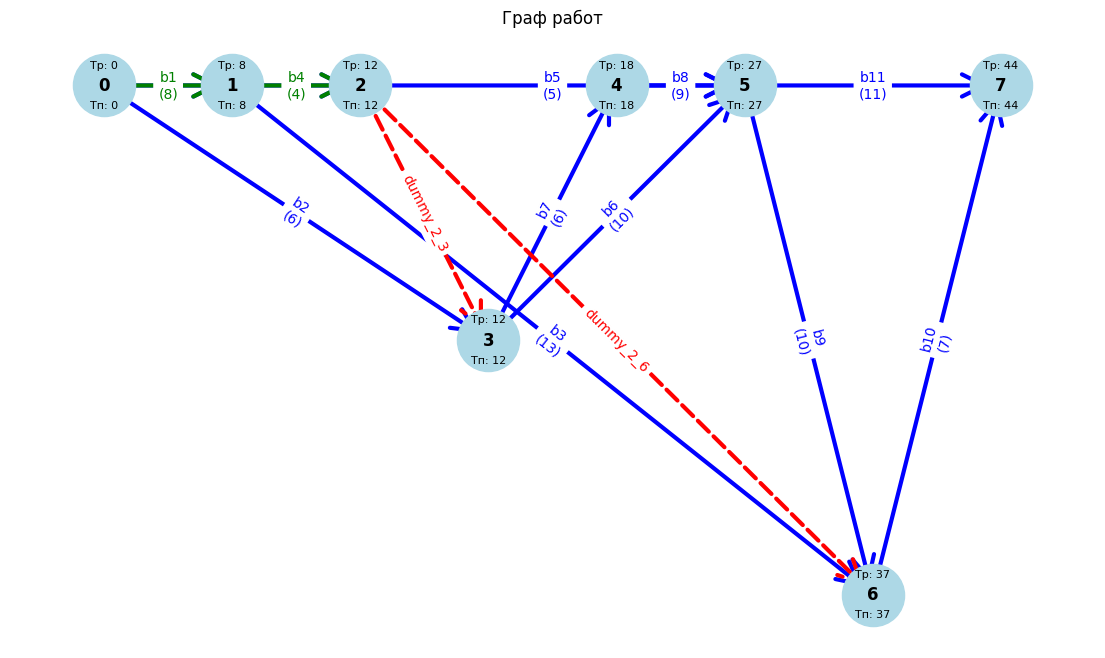

In [82]:
# Используем автоматические позиции
pos = calculate_positions(G, DUMMY_TASKS)

plt.figure(figsize=(14, 8))

# Разделяем реальные и фиктивные работы
real_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('real', True)]
dummy_edges = [(u, v) for u, v, d in G.edges(data=True) if not d.get('real', True)]

# Выделяем критические работы
critical_real_edges = [edge for edge in real_edges if edge in critical_edges]

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Рисуем реальные работы (синие сплошные)
nx.draw_networkx_edges(G, pos, edgelist=real_edges, edge_color='blue',
                      width=3, arrowstyle='->', arrowsize=40)

# Рисуем критические работы (зеленые сплошные, толще)
nx.draw_networkx_edges(G, pos, edgelist=critical_real_edges, edge_color='green',
                      width=3, arrowstyle='->', arrowsize=40)

# Рисуем фиктивные работы (красные пунктирные)
nx.draw_networkx_edges(G, pos, edgelist=dummy_edges, edge_color='red',
                      width=3, style='dashed', arrowstyle='->', arrowsize=40)

# Подписи для реальных работ
real_labels = {(u, v): f"{d.get('task', f'edge_{u}_{v}')}\n({d['duration']})" for u, v, d in G.edges(data=True) if d.get('real', True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=real_labels, font_color='blue')

# Подписи для критических работ (зеленые)
critical_labels = {(u, v): f"{G.edges[u, v].get('task', f'edge_{u}_{v}')}\n({G.edges[u, v]['duration']})" for u, v in critical_real_edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=critical_labels, font_color='green')

# Подписи для фиктивных работ
dummy_labels = {(u, v): d.get('task', f'edge_{u}_{v}') for u, v, d in G.edges(data=True) if not d.get('real', True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=dummy_labels, font_color='red')

# Добавление меток для ранних и поздних сроков
early_labels = {node: f"Tр: {early_times[node]}" for node in G.nodes}
late_labels = {node: f"Tп: {late_times[node]}" for node in G.nodes}

# Позиции для меток
early_pos = {node: (x, y + 0.02) for node, (x, y) in pos.items()}
late_pos = {node: (x, y - 0.02) for node, (x, y) in pos.items()}

# Рисуем метки для ранних сроков
nx.draw_networkx_labels(G, early_pos, labels=early_labels, font_size=8)

# Рисуем метки для поздних сроков
nx.draw_networkx_labels(G, late_pos, labels=late_labels, font_size=8)
plt.title("Граф работ")
plt.axis('off')
plt.show()